# Jun 30th, 2022 (find max pi sym - seeds, prune or not: 512)

**Motivation**: final: ???  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def sort_pi_dict(pi_dict):
    pi_sorted = pi_dict.copy()
    for i in range(len(pi_dict)):
        lbl, x = list(pi_dict.items())[i]
        if i == 0:
            continue
        src = list(pi_sorted.values())[i - 1]
        gmap = find_best_mappings(
            centroids=src,
            data={0: x},
            match_metric='cosine',
            global_order='infer',
        )[0]
        ids = list(gmap.values())
        ids = ids + list(np.delete(range(len(x)), ids))
        pi_sorted[lbl] = x[ids]
    return pi_sorted



def _get_df():
    dlist = []
    for kk, pi in pi_all.items():
        for i in range(1, pi.shape[-3] + 1):
            x = avg(pi[..., range(0, i), :, :])
            ovp, disj = bt.symmetry_score(x, decimals=10)
            dlist.append({
                'k': [kk] * len(ovp),
                'seeds': [i] * len(ovp),
                'label': ['ovp'] * len(ovp),
                'condition': ['raw'] * len(ovp),
                'oc_idx': ovp.keys(),
                'score': ovp.values(),
            })
            dlist.append({
                'k': [kk] * len(disj),
                'seeds': [i] * len(disj),
                'label': ['disj'] * len(disj),
                'condition': ['raw'] * len(disj),
                'oc_idx': disj.keys(),
                'score': disj.values(),
            })
    for kk, pi in pi_pr_all.items():
        for i in range(1, pi.shape[-3] + 1):
            x = avg(pi[..., range(0, i), :, :])
            ovp, disj = bt.symmetry_score(x, decimals=10)
            dlist.append({
                'k': [kk] * len(ovp),
                'seeds': [i] * len(ovp),
                'label': ['ovp'] * len(ovp),
                'condition': ['prune'] * len(ovp),
                'oc_idx': ovp.keys(),
                'score': ovp.values(),
            })
            dlist.append({
                'k': [kk] * len(disj),
                'seeds': [i] * len(disj),
                'label': ['disj'] * len(disj),
                'condition': ['prune'] * len(disj),
                'oc_idx': disj.keys(),
                'score': disj.values(),
            })
    df = pd.DataFrame(merge_dicts(dlist))
    return df

## Prepare (128)

In [3]:
nn = 128
fig_dir = pjoin(fig_base_dir, 'paper2.0', 'pi_ctx', f'n{nn}')
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': False,
    'bbox_inches': 'tight',
    'dpi': 200,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/pi_ctx/n128

In [4]:
mice = Mice(nn)

_BOLD = 'BOLD'
_CAS = r'Ca$^{2\!\!+}$' + ' (slow)'
_CAF = r'Ca$^{2\!\!+}$' + ' (fast)'
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {_BOLD: rocket(0.6), _CAS: mako(0.6), _CAF: to_rgb('C8')} # mako(0.3)}

In [5]:
task = 'rest'
mice.setup_func_data(task, band_ca=(0.01, 0.5))

num_k, p = 25, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}
bs = Base(**props_ca)

In [6]:
kk_ca = range(3, 21, 1)
kk_bo = range(3, 21, 1)

### Ca2 (slow)

In [7]:
mice.setup_func_data(task, band_ca=(0.01, 0.5))

pi_all = {}
pi_pr_all = {}
for kk in kk_ca:
    props_ca['num_k'] = kk
    bt = BootStrap(**props_ca)
    pi_all[kk] = bt.run_pi
    pi_pr_all[kk] = bt.pi_prune

#### How many seeds to avg?

In [8]:
%%time

df = _get_df()

CPU times: user 14min 56s, sys: 12min 28s, total: 27min 24s
Wall time: 27min 37s


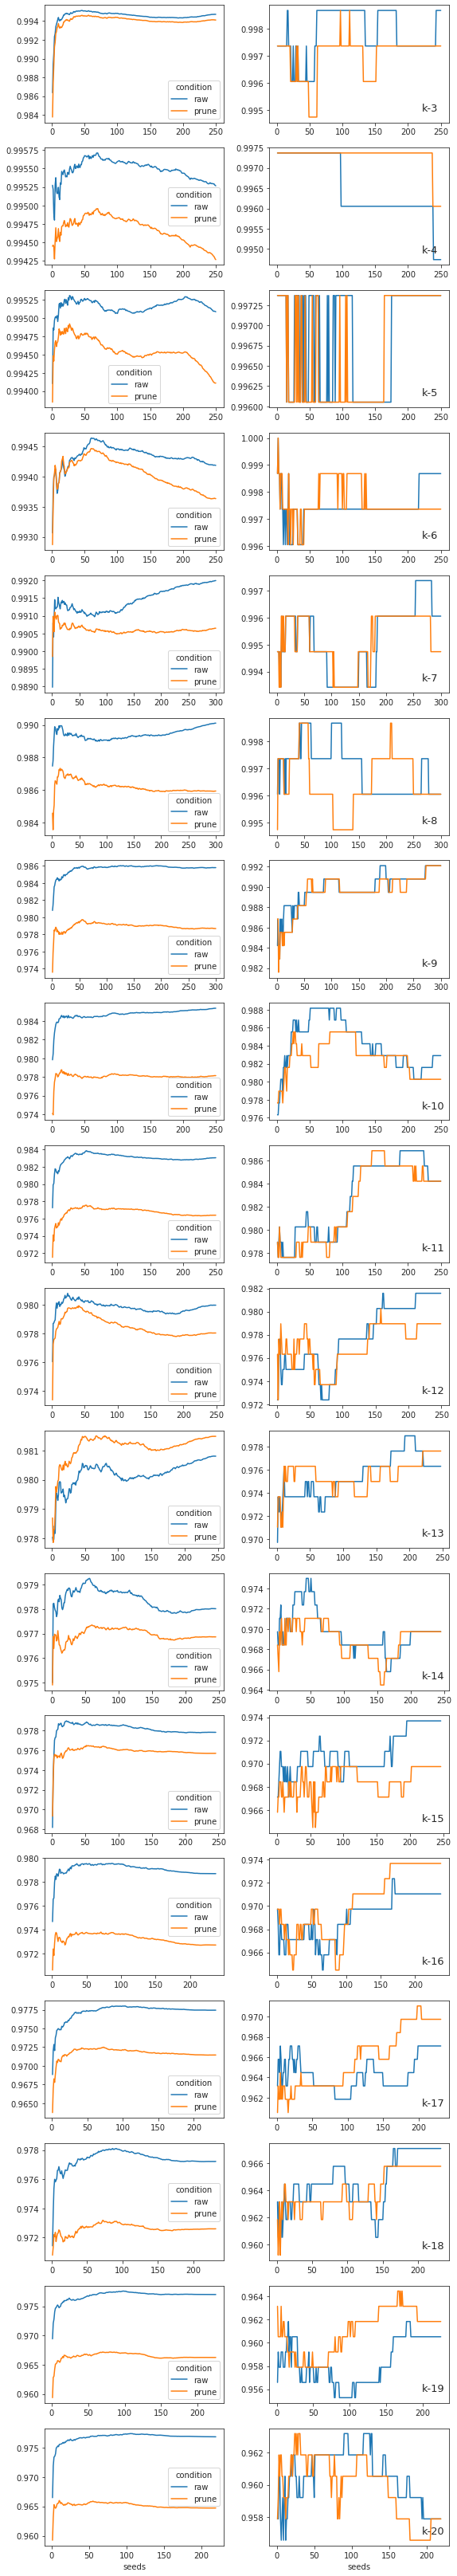

In [9]:
nrows = len(df['k'].unique())
fig, axes = create_figure(nrows, 2, (8, 2.5 * nrows))
for i, kk in enumerate(df['k'].unique()):
    for ax, lbl in zip(axes[i], df['label'].unique()):
        _df = df.loc[
            (df['oc_idx'] == -1) &
            (df['label'] == lbl) &
            (df['k'] == kk)
        ]
        sns.lineplot(
            data=_df,
            x='seeds',
            y='score',
            hue='condition',
            legend=True if
            lbl == 'ovp'
            else False,
            ax=ax,
        )
        if lbl == 'disj':
            ax.annotate(
                text=f"k-{kk}",
                xy=(0.85, 0.1),
                xycoords='axes fraction',
                fontsize=13,
            )
        ax.set_ylabel('')
        if i < nrows - 1:
            ax.set_xlabel('')
plt.show()

In [10]:
df = df.loc[df['oc_idx'] == -1].drop(columns=['oc_idx'])
df = df.groupby(['k', 'seeds', 'condition']).mean()
df = df.reset_index()

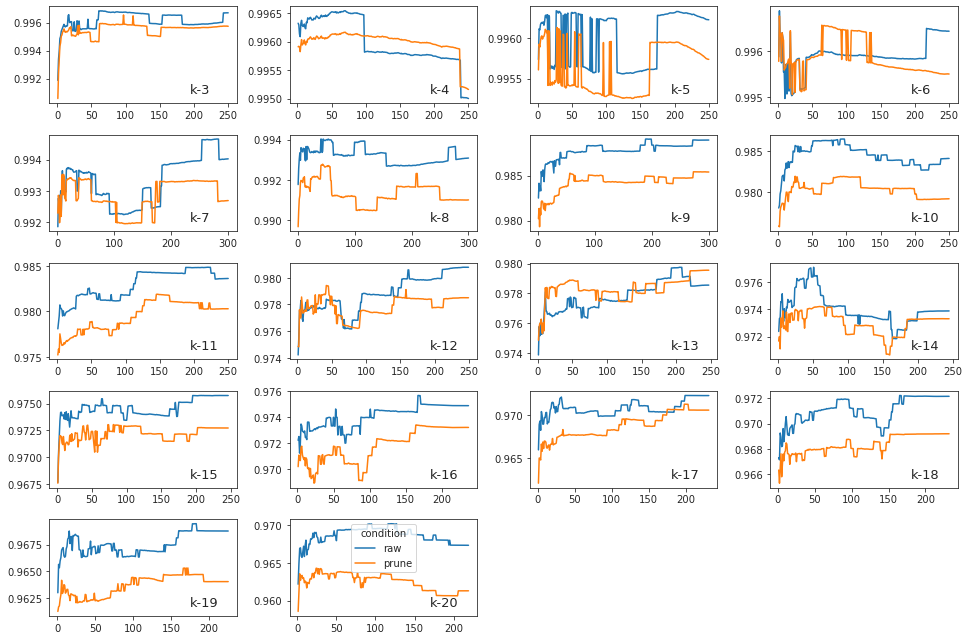

In [11]:
ncols = 4
nrows = int(np.ceil(len(df['k'].unique()) / ncols))
fig, axes = create_figure(nrows, ncols, (13.5, 9))
for i, kk in enumerate(df['k'].unique()):
    _df = df.loc[df['k'] == kk]
    ax = axes.flat[i]
    sns.lineplot(
        data=_df,
        x='seeds',
        y='score',
        hue='condition',
        hue_order=['raw', 'prune'],
        legend=True if kk == df['k'].max() else False,
        ax=ax,
    )
    ax.annotate(
        text=f"k-{kk}",
        xy=(0.75, 0.1),
        xycoords='axes fraction',
        fontsize=13,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
trim_axs(axes, len(df['k'].unique()))
plt.show()

### Ca2 (fast)

In [12]:
mice.setup_func_data(task, band_ca=0.5)

pi_all = {}
pi_pr_all = {}
for kk in kk_ca:
    props_ca['num_k'] = kk
    bt = BootStrap(**props_ca)
    pi_all[kk] = bt.run_pi
    pi_pr_all[kk] = bt.pi_prune

#### How many seeds to avg?

In [13]:
%%time

df = _get_df()

CPU times: user 12min 42s, sys: 8min 3s, total: 20min 46s
Wall time: 20min 57s


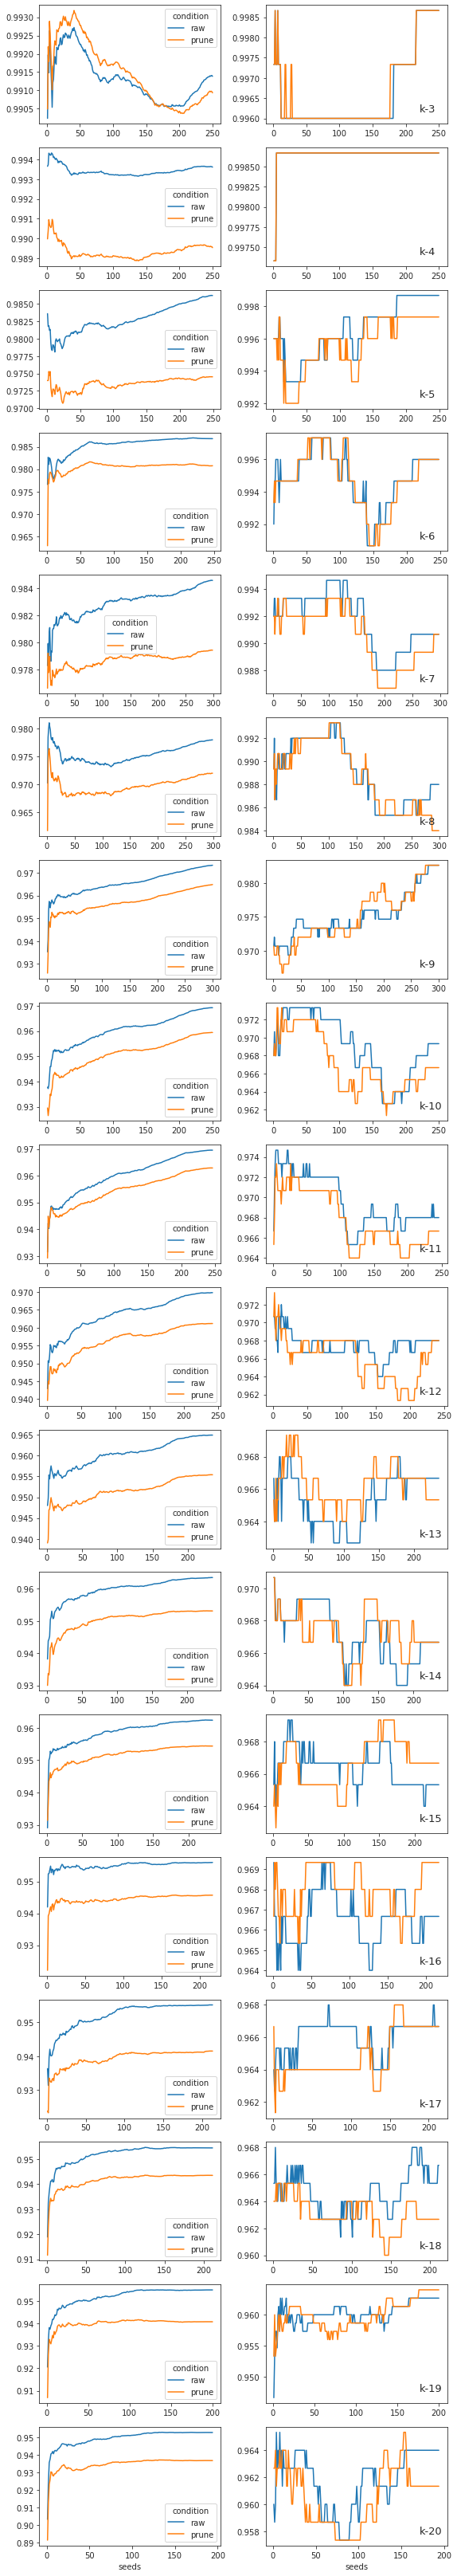

In [14]:
nrows = len(df['k'].unique())
fig, axes = create_figure(nrows, 2, (8, 2.5 * nrows))
for i, kk in enumerate(df['k'].unique()):
    for ax, lbl in zip(axes[i], df['label'].unique()):
        _df = df.loc[
            (df['oc_idx'] == -1) &
            (df['label'] == lbl) &
            (df['k'] == kk)
        ]
        sns.lineplot(
            data=_df,
            x='seeds',
            y='score',
            hue='condition',
            legend=True if
            lbl == 'ovp'
            else False,
            ax=ax,
        )
        if lbl == 'disj':
            ax.annotate(
                text=f"k-{kk}",
                xy=(0.85, 0.1),
                xycoords='axes fraction',
                fontsize=13,
            )
        ax.set_ylabel('')
        if i < nrows - 1:
            ax.set_xlabel('')
plt.show()

In [15]:
df = df.loc[df['oc_idx'] == -1].drop(columns=['oc_idx'])
df = df.groupby(['k', 'seeds', 'condition']).mean()
df = df.reset_index()

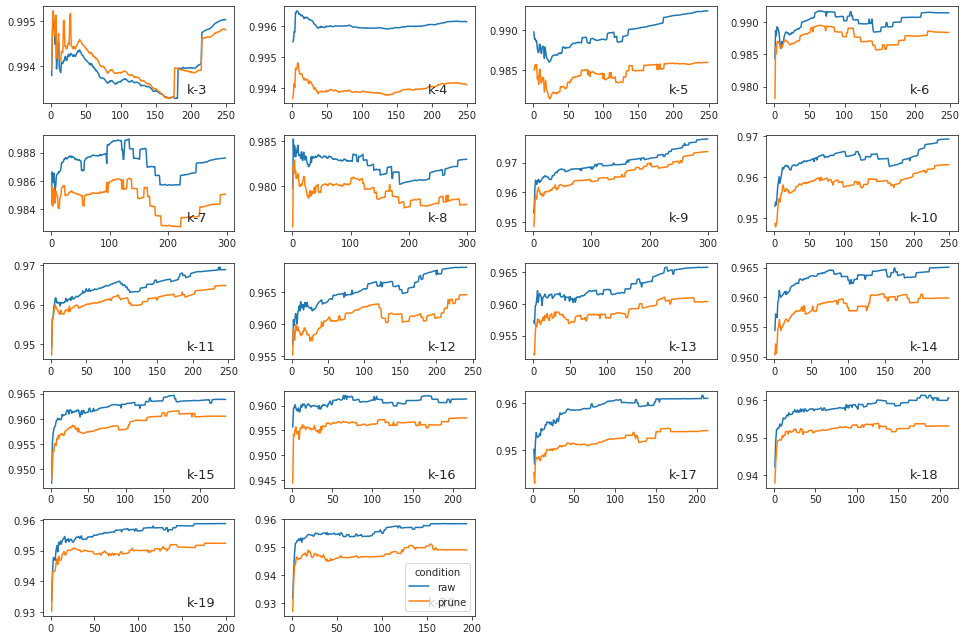

In [16]:
ncols = 4
nrows = int(np.ceil(len(df['k'].unique()) / ncols))
fig, axes = create_figure(nrows, ncols, (13.5, 9))
for i, kk in enumerate(df['k'].unique()):
    _df = df.loc[df['k'] == kk]
    ax = axes.flat[i]
    sns.lineplot(
        data=_df,
        x='seeds',
        y='score',
        hue='condition',
        hue_order=['raw', 'prune'],
        legend=True if kk == df['k'].max() else False,
        ax=ax,
    )
    ax.annotate(
        text=f"k-{kk}",
        xy=(0.75, 0.1),
        xycoords='axes fraction',
        fontsize=13,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
trim_axs(axes, len(df['k'].unique()))
plt.show()

### BOLD

In [17]:
pi_all = {}
pi_pr_all = {}
for kk in kk_bo:
    props_bo['num_k'] = kk
    bt = BootStrap(**props_bo)
    pi_all[kk] = bt.run_pi
    pi_pr_all[kk] = bt.pi_prune

In [18]:
%%time

df = _get_df()

CPU times: user 59min 3s, sys: 37min 14s, total: 1h 36min 17s
Wall time: 1h 36min 39s


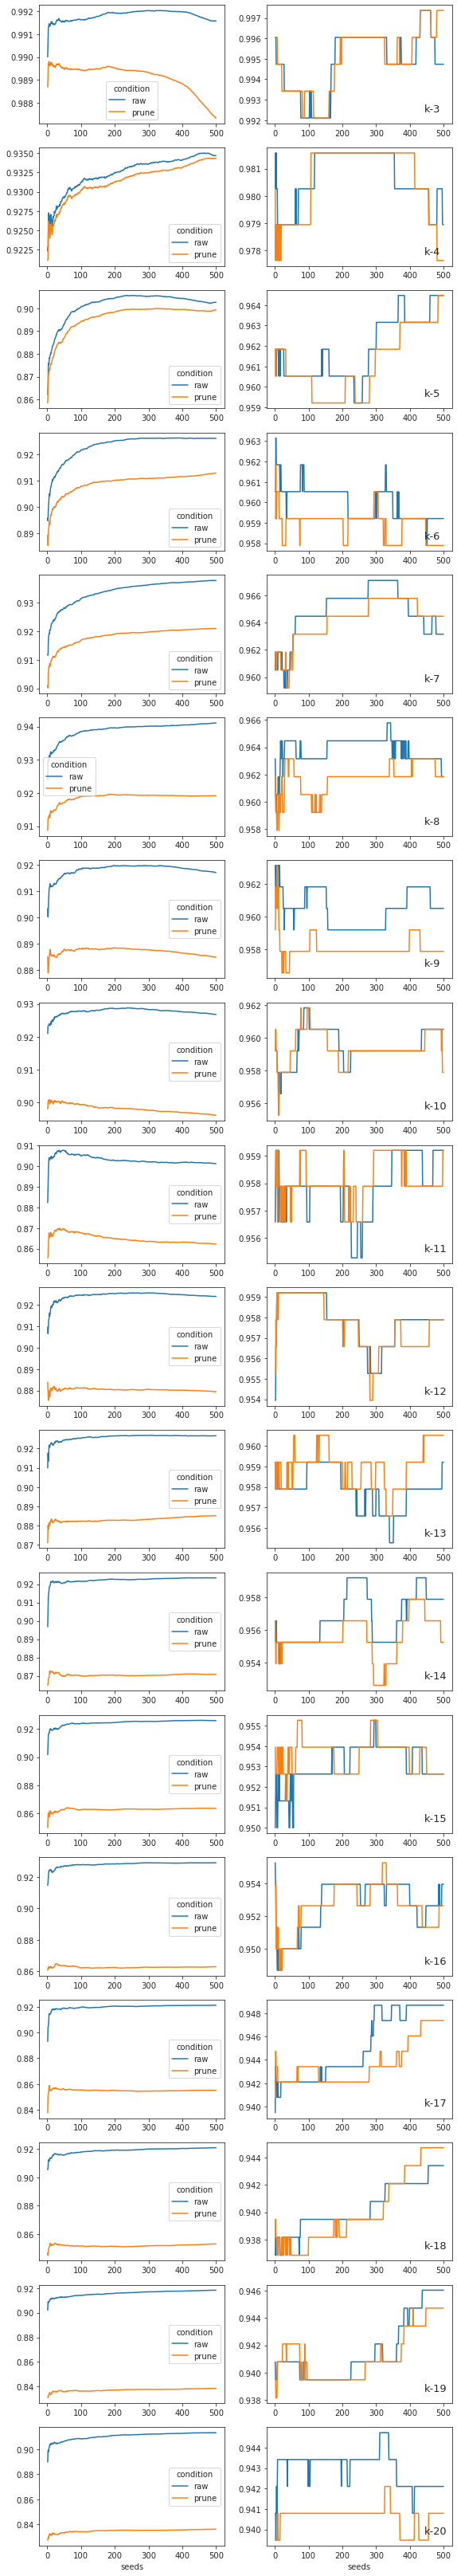

In [19]:
nrows = len(df['k'].unique())
fig, axes = create_figure(nrows, 2, (8, 2.5 * nrows))
for i, kk in enumerate(df['k'].unique()):
    for ax, lbl in zip(axes[i], df['label'].unique()):
        _df = df.loc[
            (df['oc_idx'] == -1) &
            (df['label'] == lbl) &
            (df['k'] == kk)
        ]
        sns.lineplot(
            data=_df,
            x='seeds',
            y='score',
            hue='condition',
            legend=True if
            lbl == 'ovp'
            else False,
            ax=ax,
        )
        if lbl == 'disj':
            ax.annotate(
                text=f"k-{kk}",
                xy=(0.85, 0.1),
                xycoords='axes fraction',
                fontsize=13,
            )
        ax.set_ylabel('')
        if i < nrows - 1:
            ax.set_xlabel('')
plt.show()


In [20]:
df = df.loc[df['oc_idx'] == -1].drop(columns=['oc_idx'])
df = df.groupby(['k', 'seeds', 'condition']).mean()
df = df.reset_index()

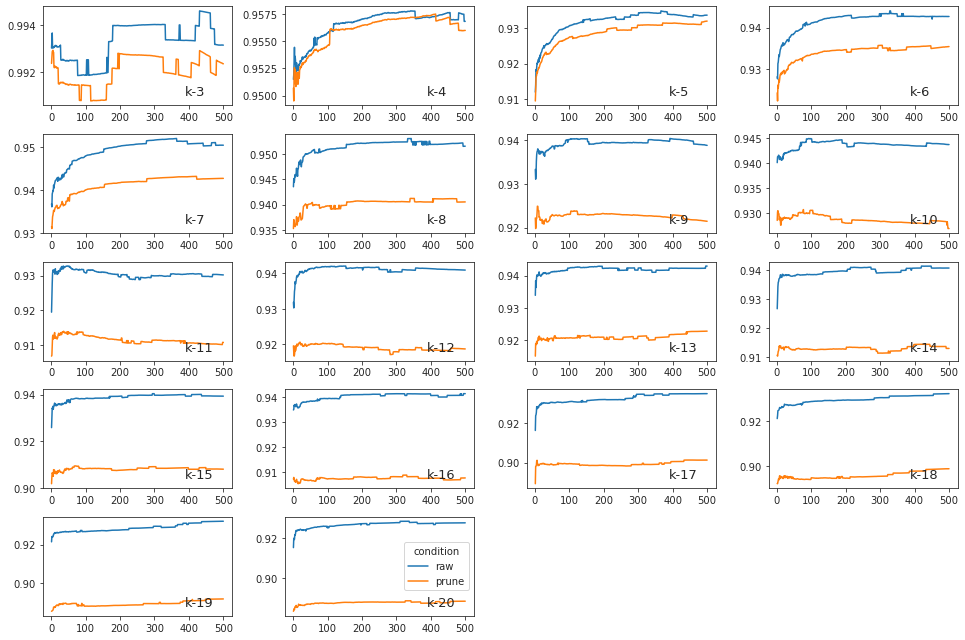

In [21]:
ncols = 4
nrows = int(np.ceil(len(df['k'].unique()) / ncols))
fig, axes = create_figure(nrows, ncols, (13.5, 9))
for i, kk in enumerate(df['k'].unique()):
    _df = df.loc[df['k'] == kk]
    ax = axes.flat[i]
    sns.lineplot(
        data=_df,
        x='seeds',
        y='score',
        hue='condition',
        hue_order=['raw', 'prune'],
        legend=True if kk == df['k'].max() else False,
        ax=ax,
    )
    ax.annotate(
        text=f"k-{kk}",
        xy=(0.75, 0.1),
        xycoords='axes fraction',
        fontsize=13,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
trim_axs(axes, len(df['k'].unique()))
plt.show()

### BOLD - mg

In [22]:
thres = 0.5
pi_all = {}
pi_pr_all = {}
for kk in kk_bo:
    props_bo['num_k'] = kk + 1
    bt = BootStrap(**props_bo)
    if not hasattr(bt, 'run_pi') or kk == 3:
        continue
    pi_all[kk] = bt._merge_vis(pi=bt.run_pi, thres=thres)[0]
    pi_pr_all[kk] = bt._merge_vis(pi=bt.pi_prune, thres=thres)[0]

In [23]:
%%time

df = _get_df()

CPU times: user 1h 6min 52s, sys: 2h 46min, total: 3h 52min 53s
Wall time: 3h 53min 37s


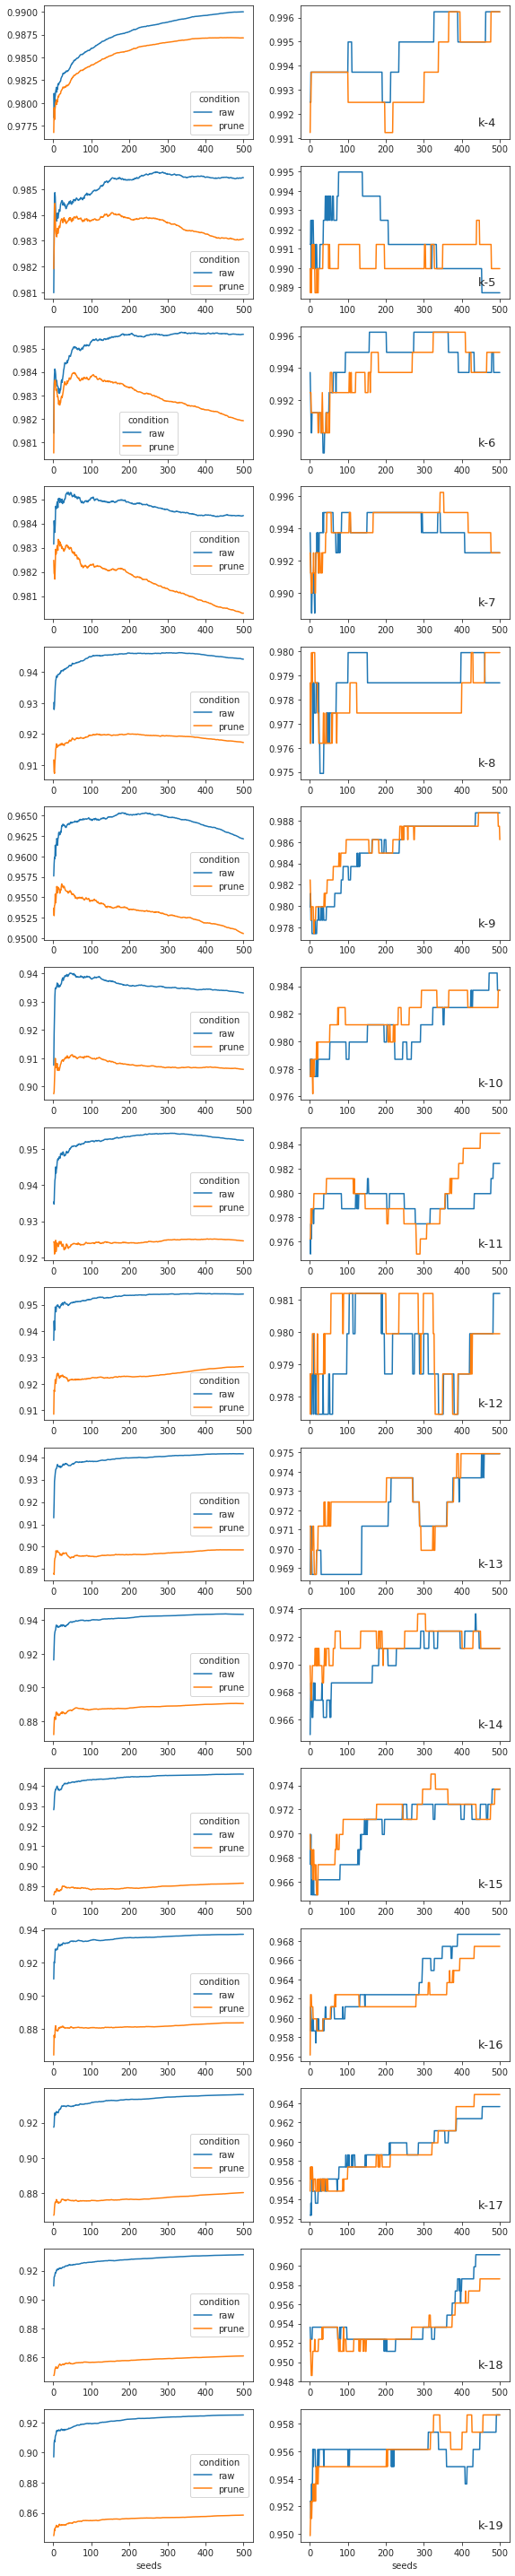

In [24]:
nrows = len(df['k'].unique())
fig, axes = create_figure(nrows, 2, (8, 2.5 * nrows))
for i, kk in enumerate(df['k'].unique()):
    for ax, lbl in zip(axes[i], df['label'].unique()):
        _df = df.loc[
            (df['oc_idx'] == -1) &
            (df['label'] == lbl) &
            (df['k'] == kk)
        ]
        sns.lineplot(
            data=_df,
            x='seeds',
            y='score',
            hue='condition',
            legend=True if
            lbl == 'ovp'
            else False,
            ax=ax,
        )
        if lbl == 'disj':
            ax.annotate(
                text=f"k-{kk}",
                xy=(0.85, 0.1),
                xycoords='axes fraction',
                fontsize=13,
            )
        ax.set_ylabel('')
        if i < nrows - 1:
            ax.set_xlabel('')
plt.show()


In [25]:
df = df.loc[df['oc_idx'] == -1].drop(columns=['oc_idx'])
df = df.groupby(['k', 'seeds', 'condition']).mean()
df = df.reset_index()

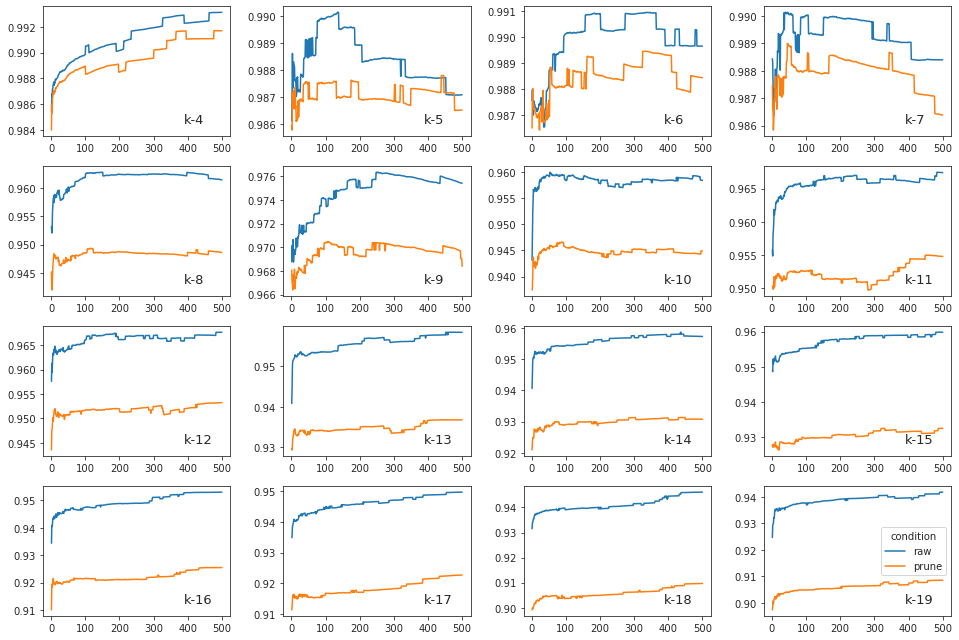

In [26]:
ncols = 4
nrows = int(np.ceil(len(df['k'].unique()) / ncols))
fig, axes = create_figure(nrows, ncols, (13.5, 9))
for i, kk in enumerate(df['k'].unique()):
    _df = df.loc[df['k'] == kk]
    ax = axes.flat[i]
    sns.lineplot(
        data=_df,
        x='seeds',
        y='score',
        hue='condition',
        hue_order=['raw', 'prune'],
        legend=True if kk == df['k'].max() else False,
        ax=ax,
    )
    ax.annotate(
        text=f"k-{kk}",
        xy=(0.75, 0.1),
        xycoords='axes fraction',
        fontsize=13,
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
trim_axs(axes, len(df['k'].unique()))
plt.show()